# Kahan Summation

The goal of this notebook is to propose and study an implementation of the Kahan summation. We started by a trivial example demonstrated the difference between the standard summation and our Kahan summation focusing on how this difference varies with the number of elements added. Then we study the impact of the order of the elements in the input on both summations shown the stability of the Kahan summation relatively to the standard sum as well as its accuracy. During the experiment we paid a close attention to the potential reproducibility issues hence we use a high quality pseudo random number generator from the https://en.wikipedia.org/wiki/CLHEP. 

## Kahan Summation implementation 

In [175]:
def kahan_sum(x):
    """Compute the sum of the elements in iterable x using Kahan summation."""
    
    _sum = 0.0
    c = 0.0
    for idx, val in enumerate(x):
        y = val - c
        t = _sum + y
        c = (t - _sum) - y
        _sum = t
    return _sum

### Example

In [176]:
sum([.1 for _ in range(1000)]) 

99.9999999999986

In [177]:
kahan_sum([.1 for _ in range(1000)])

100.0

This simple example shows an improvement on the task of summing 0.1 1000 times when using the Kahan summation instead of the standard _sum_ method.

In theory, the Kahan summation is not dependent on the number of elements that we sum whereas the standard sum is, let's see if we can illustrate that.
We are going to plot the residual error on the sum of 0.1 k times as k increases using the two different summation approach 

In [178]:
def get_sum(k, use_kahan=False, n=0.1):
    """Return the result of the summation of k times n using the standard or Kahan algorithm."""
    if use_kahan:
        return kahan_sum([n for _ in range(k)])
    else:
        return sum([n for _ in range(k)])

In [109]:
x = list(range(1000, 10000, 100)) ## input
y = [abs((_x/10.) - get_sum(_x)) for _x in x] ## residuals using standard sum 
y_kahan = [abs((_x/10.) - get_sum(_x, use_kahan=True)) for _x in x] ## residuals using Kahan sum

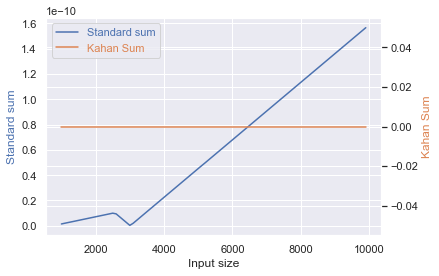

In [110]:
from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.pyplot as plt

host = host_subplot(111)

par = host.twinx()

host.set_xlabel("Input size")
host.set_ylabel("Standard sum")
par.set_ylabel("Kahan Sum")

p1, = host.plot(x, y, label="Standard sum")
p2, = par.plot(x, y_kahan, label="Kahan Sum")

leg = plt.legend()

host.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())

par.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

plt.show()

As expected, the error of the standard sum increases with the size of the input whereas the Kahan summation seems to remain constant and close if not equal to zero.

## Approximate Pi

We wrote a small C++ program that runs 100 Posix threads (each of them computing PI with a different random stream) - they return their approximations in an array which is filled in a different order from one execution to the other (depending on the termination times of threads). The file _data.txt_ contains the output of this experiment where each line corresponds to one approximation of one thread. The file contains 1000 runs of the experiment. The goal is to apply the standard summation to each run and see how it differs from the Kahan summation. We are going to plot the dispersion of the error from one execution to the other. We define the error as the difference between the true value of Pi (up to 5 decimals) and the average of the results of the 100 threads. The average being computed using the standard sum first then the Kahan sum.    

In [111]:
import pandas as pd

In [123]:
data = pd.read_csv("./data.txt", header=None).values.flatten()

In [170]:
y = []
y_kahan = [] 
for i in range(100, len(data)+1, 100):
    x = data[i-100:i]
    y.append(abs((sum(x)/100.) - 3.14159)) 
    y_kahan.append(abs((kahan_sum(x)/100.) - 3.14159)) 

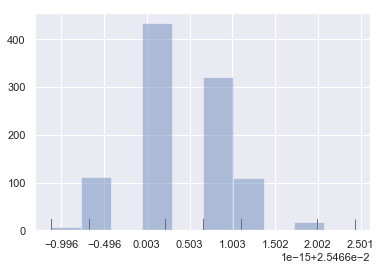

In [179]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(y, bins=10, kde=False, rug=True);

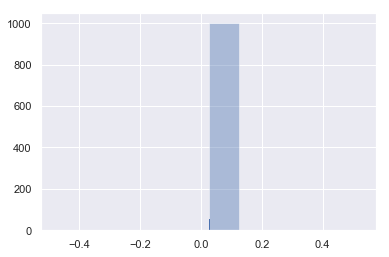

In [180]:
sns.distplot(y_kahan, bins=10, kde=False, rug=True);

We observe two things here: 
1. The standard sum seems to be sensitive to the order of the values in the input whereas the Kahan summation looks stable.
2. The Kahan summation yields a perfect approximation of Pi (up to 5 decimals) whereas the standard sum has always a non-negative residual.